## This pipeline selects images matching certain criteria related to their detections, outlines them, then creates a mosaic

In [45]:
import requests
from dotenv import load_dotenv
from os import getenv

import pandas as pd
import numpy as np
import random

import sqlite3
import json
import re
import os
import sys
local_modules = os.path.join(os.getcwd(), '..','..','src')
sys.path.append(local_modules)

#sys.path.append("D:\\projects\\geo_image_experiments\\src")

import importlib
import mapillary_utils as mu
importlib.reload(mu)
import image_processing_utils as ipu
importlib.reload(ipu)
#from image_db_interface import DatabaseManager as idi
import image_db_interface as idi
importlib.reload(idi)
import image_and_detection_selector as ids
importlib.reload(ids)
import detection_analysis_utils as dau
importlib.reload(dau)

from datetime import datetime
import uuid

## assumes a file structure like this:
1) root (any arbitrary location on your local filesystem for images and a db file)
2) root/{database file}
3) root/images/{image files}
4) root/temp_images/

## Environmental Variables: Generally set it and forget it

In [46]:
load_dotenv()
API_KEY = getenv("MAPILLARY_CLIENT_TOKEN")
api_key = API_KEY
base_dir = "D://projects_working_directories//202408_pano_images//images"

target_database = "360_images_2024-09-08.db"
db_path = f"d://projects_working_directories//202408_pano_images//{target_database}"

# where to save images after processing
save_loc = "D://projects_working_directories//temp_images//"


### utility_load_sample_images:
The images and detections found in prior sampling (01_get_all_pano_images and 02_acquire_sample_images) have their metadata stored in a sqlite db. There are 2 tables:
1) sampled_images, which have basic metadata about the image coming from mapillary
2) image_detections, which has metadata about the detections in the image (TODO: this would better be renamed "image_detection_metadata") - this tables has summarized info about the detections, specifically, how many features there are for any given detection label, and the detection_prct_of_image, which gives a rough estimate of the amount of the image that's consumed by that particular detection.

In [47]:
db = idi.DatabaseManager(db_path)

# Connect to the database
db.connect()


sql = """select * from sampled_images"""
df_images = db.fetch_data(sql)

sql = """select * from image_detections"""
df_image_detections = db.fetch_data(sql)


Connected to d://projects_working_directories//202408_pano_images//360_images_2024-09-08.db


## selection criteria
The next section is broken out into 2 basic sections
1) you set the variable "detection_match" to be a substring of the detection(s) you want to view. As the detection labels are hierarchichal in nature, what's been implemented is a wildcard on the back of the string (TODO: not sure why that was necessary constraint... look into making it just a general wildcard.) So in the first box you can play around with the substring that will return the labels you're interested in, fine tune, etc.
2) In the second box, you pass the list of returned detections into another function, along with 2 other variables: Threshold, an int from 0-100, which indicates what percent you want the aggregation of all the detections should make up of the image to be returned. and match_strat, which can be 'threshold' or 'all' - threshold is the default. If all is selected, then only images that contain all detections you passed in will be returned. 

In [48]:
## play around with selecting detections. Passing in a blank string will return everything
detection_match = 'construction--barrier'

selected_detections = ids.select_detections(df_image_detections, detection_match)
[f'{x}\n' for x in selected_detections]

['construction--barrier--concrete-block\n',
 'construction--barrier--curb\n',
 'construction--barrier--fence\n',
 'construction--barrier--guard-rail\n',
 'construction--barrier--road-median\n',
 'construction--barrier--road-side\n',
 'construction--barrier--separator\n',
 'construction--barrier--temporary\n',
 'construction--barrier--wall\n']

In [59]:
## once you're happy with the selections above, pass it in to this.
threshold = 10
match_strat = 'threshold'  # alt: all
sample_count = 2 # after finding candidate images, how many samples do you want to take for further study?


matched_images = ids.find_images_matching(df_image_detections, selected_detections, threshold=threshold, match_strat=match_strat)
print(f"found: {len(matched_images)} images that match requirements")
sampled_images = random.sample(matched_images, sample_count)

original detections count is 227443
after filtering for desired detections: 19412
found: 191 images that match requirements


## utility_show_detections
Once you've selected your sample images, cycle through them, get the actual images and detections from mapillary, process them, and generate/save images with overlaid masks or outlines around the selected detections. An example output would be something like this:

### When you use the 'outline' parameter

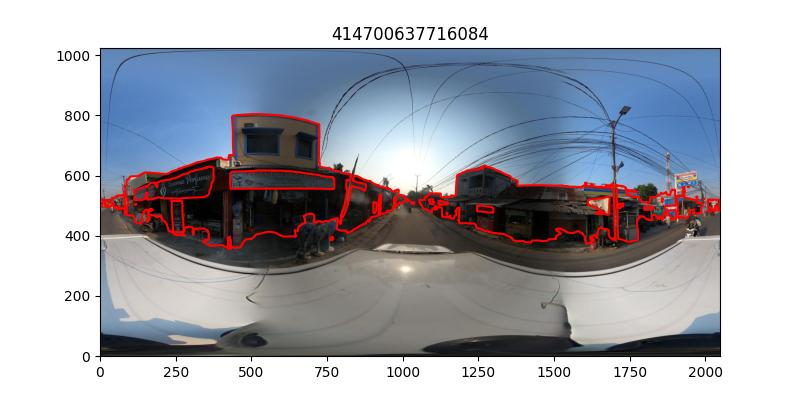

### When you use the 'fill' parameter, the outline will be colored in
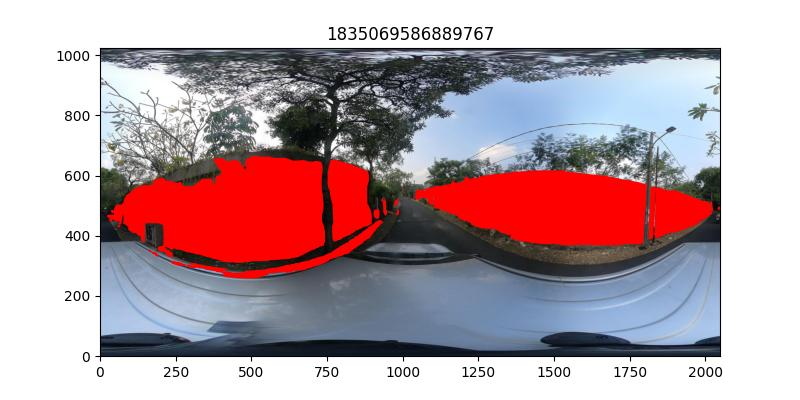


In [63]:
display = 'outline' #alt: fill
color = 'red'


In [65]:
for image_id in sampled_images:

    image, metadata = mu.get_mapillary_image(image_id, api_key, image_size_indicator='thumb_2048_url', image_dir=base_dir)
    ## to make the format compatible
    #metadata={}
    #metadata['height'] = df_images.height[df_images.image_id == image_id].tolist()[0]
    #metadata['width'] = df_images.width[df_images.image_id == image_id].tolist()[0]
    ## end: to make the format compatible
    
    detections = mu.get_mapillary_detections(image_id, api_key)
    df_detections = mu.extract_detections(detections)
    
    arrays = df_detections.apply(lambda x: mu.decode_base64_geometry_fromdf(x, normalize=True, image_height=metadata['height'],\
                                                                                             image_width=metadata['width']), axis=1)
    
    temp_df = [pd.DataFrame(arr, columns=['image_id', 'detection_id','detection_label','feature_id', 'image_height', 'image_width', 'extent','properties','coordinates']) for arr in arrays]
    df_detection_coords = pd.concat(temp_df, ignore_index=True)
    
    
    
    fig = dau.draw_polygons(df_detection_coords[df_detection_coords.detection_label.isin(selected_detections)].coordinates.tolist(),\
                                 max_x=image.size[0], max_y=image.size[1], display=display, image_underlay=image, color=color, title=metadata['image_id'])
    fig.savefig(f"{save_loc}detections_{image_id}_{display}.jpg")
